In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Pre-Processing

In [3]:
netflix = pd.read_csv('../data/final_data/netflix_final_data.csv')
ratings = pd.read_csv('../data/raw/title.ratings.tsv', sep='\t')
basics = pd.read_csv('../data/raw/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'])


C:\Users\Joeyz\AppData\Local\Temp\ipykernel_1828\4153742094.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics = pd.read_csv('../data/raw/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'])


### Merging and Cleaning Further

In [6]:
df = netflix.merge(ratings, how='left', on='tconst').merge(basics, how='left', on='tconst', )

In [7]:
#My Wonderful Life Manually added data

df.loc[df['title']=='my wonderful life', 'averageRating'] = 5.9
df.loc[df['title']=='my wonderful life', 'numVotes'] = 714
df.loc[df['title']=='my wonderful life', 'titleType'] = 'movie'
df.loc[df['title']=='my wonderful life', 'runtimeMinutes'] = 99
df.loc[df['title']=='my wonderful life', 'isAdult'] = 0
df.loc[df['title']=='my wonderful life', 'genres'] = 'Comedy,Drama,Romance'

### Change isTop10 Column into Integers and Replace \\N into NaN

In [8]:
df['is_top10'] = df['is_top10'].astype(int)
df.replace('\\N', np.nan, inplace=True)

### Split into Movies and Shows

In [9]:
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

## MOVIES
### LOGISTIC REGRESSION

### Drop Columns that aren't Needed

In [10]:
# drop columns that are not needed
movies = movies.drop(['tconst', 'combined_title', 'title', 'season', 'is_tv_show', 'isAdult'], axis = 1)

In [224]:
from sklearn.model_selection import train_test_split
movies_train, movies_test = train_test_split(movies, test_size=0.3, random_state=100)

# Training set
movies_train_X = movies_train.drop(['is_top10'], axis = 1)
movies_train_Y = movies_train['is_top10']

# Test set
movies_test_X = movies_test.drop(['is_top10'], axis = 1)
movies_test_Y = movies_test['is_top10']

In [225]:
# remove any rows with NaN genres and titleType because those won't be handled by the transformer
# training set removal
indexRowsToRemove_train = movies_train_X[(movies_train_X.genres.isna()) & (movies_train_X.titleType.isna())].index
movies_train_X.drop(index = indexRowsToRemove_train[0], axis = 1, inplace = True)
movies_train_Y.drop(index = indexRowsToRemove_train[0], axis = 1, inplace = True)

# test set removal
indexRowsToRemove_test = movies_test_X[(movies_test_X.genres.isna()) & (movies_test_X.titleType.isna())].index
movies_test_X.drop(index = indexRowsToRemove_test[0], axis = 1, inplace = True)
movies_test_Y.drop(index = indexRowsToRemove_test[0], axis = 1, inplace = True)

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

In [227]:
movies_test_X.isna().sum()

release_year_x     0
averageRating      3
numVotes           3
titleType          0
runtimeMinutes    13
genres             0
dtype: int64

In [13]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),                # One hot encode title types
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),   # Impute missing ratings, votes, and runtime with the average
    ("bagofw", CountVectorizer(), 'genres')                                                         # Splits genres into bag of words and encode them
    ],
    remainder='passthrough')

In [229]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import sklearn.preprocessing
import sklearn.linear_model

# make sklearn pipeline with transform, normalization, and model
pipeLogReg = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('logistic_regress', sklearn.linear_model.LogisticRegression(max_iter = 1000))      # Build logistic Regression model
        
    ]
)    

In [230]:
# use grid search to cross validate logistic regression model - 5-fold cross validation
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    pipeLogReg,
    param_grid={
        'logistic_regress__C': [0.01, 0.1, 1, 10, 100],
        'logistic_regress__solver': ['lbfgs','saga'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [231]:
gs.fit(movies_train_X, movies_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [232]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gs.best_params_
gs.best_score_
best_logistic = gs.best_estimator_

In [233]:
best_logistic

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['titleType']),
                                                 ('imputer', SimpleImputer(),
                                                  ['averageRating', 'numVotes',
                                                   'runtimeMinutes']),
                                                 ('bagofw', CountVectorizer(),
                                                  'genres')])),
                ('normalizer', Normalizer()),
                ('standardizer', StandardScaler(with_mean=False)),
                ('logistic_regress',
                 LogisticRegression(C=0.01, max_iter=1000))])

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy:  0.6636363636363637
AUC:  0.7308075772681953


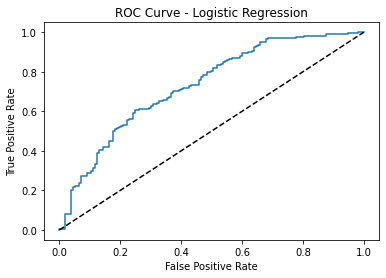

In [234]:
best_logistic.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_logistic.predict_proba(movies_test_X)[:,1]
y_pred = best_logistic.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()

### DECISION TREE (CART)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
import sklearn.preprocessing
import sklearn.linear_model

# make sklearn pipeline with transform, normalization, and model (CART)
pipeDecTree = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('decisiontree', sklearn.tree.DecisionTreeClassifier())                             # Build Decision Tree model
    ]
)    

NameError: name 'transformer' is not defined

In [236]:
# use grid search to cross validate decision tree model - 5-fold cross validation

gsDT = GridSearchCV(
    pipeDecTree,
    param_grid={
        'decisiontree__max_depth': [5, 6, 7, 8, 9, 10],
        'decisiontree__min_samples_leaf': [1, 5, 10, 15, 20],
        'decisiontree__criterion': ['gini', 'entropy', 'log_loss'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [237]:
gsDT.fit(movies_train_X, movies_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/s

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
            

In [238]:
# retrieve the best parameters and estimators returned by the grid search cross validation step
gsDT.best_params_
gsDT.best_score_
best_decisiontree = gsDT.best_estimator_

Accuracy:  0.693939393939394
AUC:  0.7338539935748312


/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


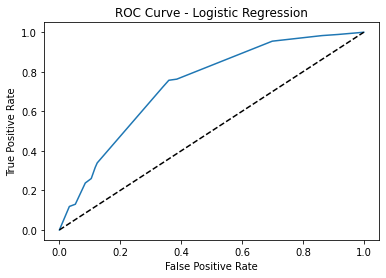

In [239]:
best_decisiontree.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_decisiontree.predict_proba(movies_test_X)[:,1]
y_pred = best_decisiontree.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()

## TV SERIES

In [14]:
# drop columns that are not needed
tv_shows = tv_shows.drop(['tconst', 'combined_title', 'title', 'is_tv_show', 'isAdult'], axis = 1)

In [15]:
from sklearn.model_selection import train_test_split
tvShows_train, tvShows_test = train_test_split(tv_shows, test_size=0.3, random_state=100)

# Training set
tvShows_train_X = tvShows_train.drop(['is_top10'], axis = 1)
tvShows_train_Y = tvShows_train['is_top10']

# Test set
tvShows_test_X = tvShows_test.drop(['is_top10'], axis = 1)
tvShows_test_Y = tvShows_test['is_top10']

In [16]:
# remove any rows with NaN seasons because those won't be handled by the transformer
# training set removal
indexRowsToRemove_train = tvShows_train_X[tvShows_train_X.season.isna()].index
tvShows_train_X.drop(index = list(indexRowsToRemove_train.values), axis = 1, inplace = True)
tvShows_train_Y.drop(index = list(indexRowsToRemove_train.values), axis = 1, inplace = True)

# # test set removal
indexRowsToRemove_test = tvShows_test_X[(tvShows_test_X.genres.isna()) | (tvShows_test_X.season.isna())].index
tvShows_test_X.drop(index = list(indexRowsToRemove_test.values), axis = 1, inplace = True)
tvShows_test_Y.drop(index = list(indexRowsToRemove_test.values), axis = 1, inplace = True)

In [17]:
tvShows_test_X.isna().sum()

release_year_x     0
season             0
averageRating      0
numVotes           0
titleType          0
runtimeMinutes    74
genres             0
dtype: int64

In [18]:
tvShows_train_X.isna().sum()

release_year_x      0
season              0
averageRating       3
numVotes            3
titleType           0
runtimeMinutes    171
genres              0
dtype: int64

In [245]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),                # One hot encode title types
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),   # Impute missing ratings, votes, and runtime with the average
    ("bagofw", CountVectorizer(), 'genres')                                                         # Splits genres into bag of words and encode them
    ],
    remainder='passthrough')

In [246]:
# use grid search to cross validate logistic regression model - 5-fold cross validation
from sklearn.model_selection import GridSearchCV

# make sklearn pipeline with transform, normalization, and model
pipeLogReg = Pipeline(
    steps=[
        ('transformer', transformer),                                                       # Transform dataset                
        ('normalizer', sklearn.preprocessing.Normalizer()),                                 # Normalise features
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),            # Rescale dataset
        ('logistic_regress', sklearn.linear_model.LogisticRegression(max_iter = 1000))      # Build logistic Regression model
        
    ]
)    

gsLR_tvShows = GridSearchCV(
    pipeLogReg,
    param_grid={
        'logistic_regress__C': [0.01, 0.1, 1, 10, 100],
        'logistic_regress__solver': ['lbfgs','saga'],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [247]:
gsLR_tvShows.fit(tvShows_train_X, tvShows_train_Y)

/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 778, in _hstack
    converted_Xs = [
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py", line 779, in <listcomp>
    check_array(X, accept_sparse=True, force_all_finite=False)
  File "/Users/yenhann/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 746, in check_array
    a

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.